# Time Series Models

## TOC

- [Random Walk Model](#random_walk)
- [Improvements on the FSM](#arma_models)
    - [Autoregressive Model](#ar_model)
    - [Moving Average Model](#ma_model)
    - [ACF and PACF](#acf_pacf)
- [auto_arima](#auto_arima)


If we think back to our lecture on the bias-variance tradeoff, a perfect model is not possible.  There will always be noise (inexplicable error).

If we were to remove all of the patterns from our time series, we would be left with white noise, which is written mathematically as:

$$\Large Y_t =  \epsilon_t$$

The error term is randomly distributed around the mean, has constant variance, and no autocorrelation.

In [1]:
# Let's make some white noise!
from random import gauss as gs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

rands = []

# Create a 1000 cycle for-loop
for _ in range(1000):
    # Append 1000 random numbers from the standard normal distribution
    rands.append(gs(0, 1))
    
series = pd.Series(rands)

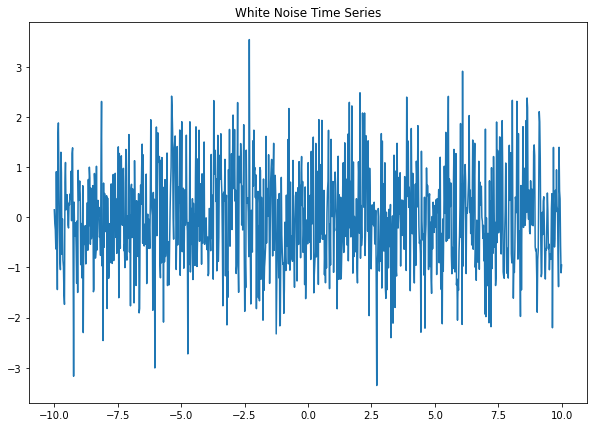

In [2]:
fig, ax = plt.subplots(figsize=(10, 7))

# Create an array with the same shape as our random gaussian series.
X = np.linspace(-10, 10, 1000)

ax.plot(X, series)
ax.set_title('White Noise Time Series');

We know this data has no true pattern governing its fluctuations (because we coded it with a random function).

Any attempt at a model would be fruitless.  The next point in the series could be any value, completely independent of the previous value.

We will assume that the timeseries data that we are working with is more than just white noise.

# Train Test Split

Let's impor chicago gun crime data, and apply some preprocessing. 


In [3]:
ts = pd.read_csv('data/Gun_Crimes_Heat_Map.csv', index_col='Date', parse_dates=True)

# ts_minute = ts.groupby('Date').count()['ID']
daily_count = ts.resample('D').count()['ID']

# Remove outliers
daily_count = daily_count[daily_count < 90]

# Create date_range object with all dates between beginning and end dates
ts_dr = pd.date_range(daily_count.index[0], daily_count.index[-1])

# Create empty series the length of the date range
ts_daily = np.empty(shape=len(ts_dr))
ts_daily = pd.Series(ts_daily)

# Add datetime index to series and fill with daily count
ts_daily = ts_daily.reindex(ts_dr)
ts_daily = ts_daily.fillna(daily_count)

# There are missing values which we fill via linear interpolation
ts_daily = ts_daily.interpolate()

# Downsample to the week level
ts_weekly = ts_daily.resample('W').mean()


In [4]:
ts

,ID,Case Number,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
Date,,,,,,,,,,,,,,,,,,,,,
2018-02-10 08:00:00,11236423,JB159764,130XX S LANGLEY AVE,051A,ASSAULT,AGGRAVATED: HANDGUN,STREET,False,False,533,...,9.0,54,04A,NaN,NaN,2018,02/22/2018 03:58:56 PM,NaN,NaN,NaN
2016-06-20 22:18:00,10568438,HZ316534,024XX E 71ST ST,031A,ROBBERY,ARMED: HANDGUN,SIDEWALK,False,False,334,...,7.0,43,03,NaN,NaN,2016,06/27/2016 03:51:44 PM,NaN,NaN,NaN
2015-06-11 20:28:00,10394395,HY298019,058XX S UNION AVE,143A,WEAPONS VIOLATION,UNLAWFUL POSS OF HANDGUN,RESIDENCE,False,False,711,...,3.0,68,15,NaN,NaN,2015,07/22/2016 03:49:06 PM,NaN,NaN,NaN
2015-08-28 11:06:00,10370206,HY400660,039XX W GRENSHAW ST,143A,WEAPONS VIOLATION,UNLAWFUL POSS OF HANDGUN,APARTMENT,False,False,1132,...,24.0,29,15,NaN,NaN,2015,08/04/2016 03:52:47 PM,NaN,NaN,NaN
2015-08-26 09:30:00,10300408,HY397968,041XX W MAYPOLE AVE,143A,WEAPONS VIOLATION,UNLAWFUL POSS OF HANDGUN,SIDEWALK,False,False,1114,...,28.0,26,15,NaN,NaN,2015,06/17/2016 03:52:24 PM,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-03-18 19:07:00,9999953,HY189822,076XX S ESSEX AVE,143A,WEAPONS VIOLATION,UNLAWFUL POSS OF HANDGUN,SIDEWALK,True,False,421,...,7.0,43,15,1194187.0,1854870.0,2015,02/10/2018 03:50:01 PM,41.756697,-87.563901,"(41.756696665, -87.563901121)"
2015-02-19 20:30:00,9999968,HY189827,033XX W EASTWOOD AVE,051A,ASSAULT,AGGRAVATED: HANDGUN,APARTMENT,True,True,1713,...,33.0,14,04A,1153359.0,1930653.0,2015,02/10/2018 03:50:01 PM,41.965558,-87.711517,"(41.965558419, -87.711517268)"
2015-03-18 17:49:00,9999986,HY189728,042XX W WILCOX ST,143A,WEAPONS VIOLATION,UNLAWFUL POSS OF HANDGUN,STREET,False,False,1115,...,28.0,26,15,1148119.0,1898998.0,2015,02/10/2018 03:50:01 PM,41.878797,-87.731600,"(41.878796866, -87.731600482)"


In [65]:
daily_count

Date
2014-01-01    50
2014-01-02    33
2014-01-03    24
2014-01-04    32
2014-01-05    17
              ..
2020-06-21    52
2020-06-22    66
2020-06-23    48
2020-06-24    58
2020-06-25    46
Name: ID, Length: 2363, dtype: int64

In [6]:
ts_dr

DatetimeIndex(['2014-01-01', '2014-01-02', '2014-01-03', '2014-01-04',
               '2014-01-05', '2014-01-06', '2014-01-07', '2014-01-08',
               '2014-01-09', '2014-01-10',
               ...
               '2020-06-16', '2020-06-17', '2020-06-18', '2020-06-19',
               '2020-06-20', '2020-06-21', '2020-06-22', '2020-06-23',
               '2020-06-24', '2020-06-25'],
              dtype='datetime64[ns]', length=2368, freq='D')

In [7]:
ts_daily

2014-01-01    50.0
2014-01-02    33.0
2014-01-03    24.0
2014-01-04    32.0
2014-01-05    17.0
              ... 
2020-06-21    52.0
2020-06-22    66.0
2020-06-23    48.0
2020-06-24    58.0
2020-06-25    46.0
Freq: D, Length: 2368, dtype: float64

Text(0.5, 1.0, 'Weekly Reports of Gun Offenses in Chicago')

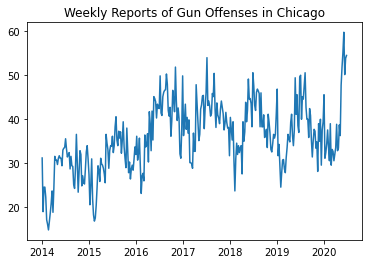

In [4]:
fig, ax = plt.subplots()
ax.plot(ts_weekly)
ax.set_title("Weekly Reports of Gun Offenses in Chicago")

Train test split for a time series is a little different than what we are used to.  Because **chronological order matters**, we cannot randomly sample points in our data.  Instead, we cut off a portion of our data at the end, and reserve it as our test set.

In [5]:
# find the index which allows us to split off 20% of the data
# Calculate the 80% mark by multiplying the row index of the shape attribute by .8
# Use the built in round function to find the nearest integer
end_of_train_index = round(ts_weekly.shape[0] * 0.8)

In [6]:
# Define train and test sets according to the index found above
train = ts_weekly[:end_of_train_index]
test = ts_weekly[end_of_train_index:]

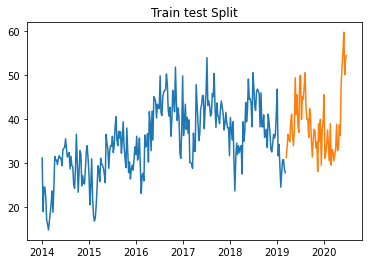

In [7]:
fig, ax = plt.subplots()
ax.plot(train)
ax.plot(test)
ax.set_title('Train test Split');

We will now set aside our test set, and build our model on the train.

<a id='random_walk'></a>

# Random Walk

A good first attempt at a model for a time series would be to simply predict the next data point with the point previous to it.  

We call this type of time series a random walk, and it is written mathematically like so.

$$\Large Y_t = Y_{t-1} + \epsilon_t$$

$\epsilon$ represents white noise error.  The formula indicates that the difference between a point and a point before it is white noise.

$$\Large Y_t - Y_{t-1}=  \epsilon_t$$

This makes sense, given one way we described making our series stationary was by applying a difference of a lag of 1.

Let's make a simple random walk model for our Gun Crime dataset.

WE can perform this with the shift operator, which shifts our time series according to periods argument.

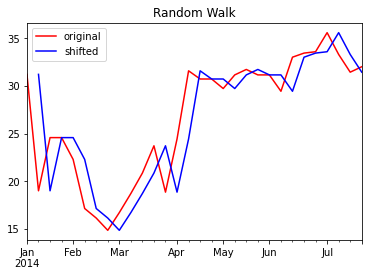

In [8]:
# The prediction for the next day is the original series shifted to the future by one day.
# pass period= 1 argument to the shift method called at the end of train.
random_walk = train.shift(1)

import matplotlib.pyplot as plt
fig, ax = plt.subplots()

train[0:30].plot(ax=ax, c='r', label='original')
random_walk[0:30].plot(ax=ax, c='b', label='shifted')
ax.set_title('Random Walk')
ax.legend();

We will use a random walk as our **FSM**.  

That being the case, let's use a familiar metric, RMSE, to assess its strength.


## Calculate RMSE

In [9]:
# Either proceed by hand or using the mean_squared_error function
# from sklearn.metrics module
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(train[1:], random_walk.dropna(), squared = False)
rmse

4.697558588175607

<a id='arma_models'></a>

# Improvement on FSM: Autoregressive and Moving Average Models

Lets plot the residuals from the random walk model.

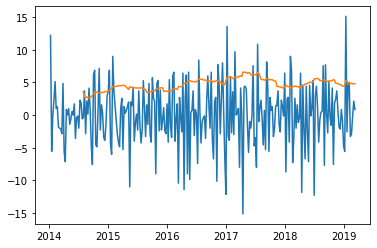

In [10]:
residuals = random_walk - train

plt.plot(residuals.index, residuals)
plt.plot(residuals.index, residuals.rolling(30).std())

In [11]:
residuals

2014-01-05          NaN
2014-01-12    12.200000
2014-01-19    -5.571429
2014-01-26     0.000000
2014-02-02     2.285714
                ...    
2019-02-10    -3.285714
2019-02-17    -2.857143
2019-02-24    -0.142857
2019-03-03     2.142857
2019-03-10     0.857143
Freq: W-SUN, Length: 271, dtype: float64

If we look at the rolling standard deviation of our errors, we can see that the performance of our model varies at different points in time.

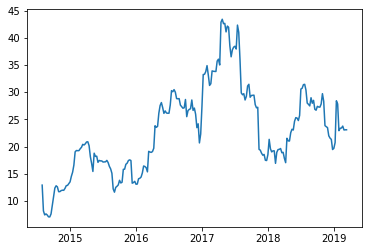

In [12]:
plt.plot(residuals.index, residuals.rolling(30).var())

That is a result of the trends in our data.

Time Series models expect to be fed **stationary** data.  Were able to make our series stationary by differencing our data.

Let's repeat that process here. 

In order to make our life easier, we will use statsmodels to difference our data via the **ARIMA** class. 

We will break down what ARIMA is shortly, but for now, we will focus on the I, which stands for **integrated**.  A time series which has been be differenced to become stationary is said to have been integrated [1](https://people.duke.edu/~rnau/411arim.htm). 

There is an order parameter in ARIMA with three slots: (p, d, q).  d represents our order of differencing, so putting a one there in our model will apply a first order difference.




In [13]:
from statsmodels.tsa.arima_model import ARIMA

In [14]:
# create an arima_model object, and pass the training set and order (0,1,0) as arguments
# then call the .fit() method
rw = ARIMA(train, (0,1,0)).fit()

# Just like our other models, we can now use the predict method. 
# Add typ='levels' argument to predict on original scale
rw.predict(typ = 'levels')

2014-01-12    31.187619
2014-01-19    18.987619
2014-01-26    24.559048
2014-02-02    24.559048
2014-02-09    22.273333
                ...    
2019-02-10    24.559048
2019-02-17    27.844762
2019-02-24    30.701905
2019-03-03    30.844762
2019-03-10    28.701905
Freq: W-SUN, Length: 270, dtype: float64

We can see that the differenced predictions (d=1) are just a random walk

In [15]:
random_walk

2014-01-05          NaN
2014-01-12    31.200000
2014-01-19    19.000000
2014-01-26    24.571429
2014-02-02    24.571429
                ...    
2019-02-10    24.571429
2019-02-17    27.857143
2019-02-24    30.714286
2019-03-03    30.857143
2019-03-10    28.714286
Freq: W-SUN, Length: 271, dtype: float64

In [16]:
# We put a typ='levels' to convert our predictions to remove the differencing performed.
y_hat = rw.predict(typ='levels')

# RMSE is equivalent to Random Walk RMSE
np.sqrt(mean_squared_error(train[1:], y_hat))

4.697542272439977

By removing the trend from our data, we assume that our data passes a significance test that the mean and variance are constant throughout.  But it is not just white noise.  If it were, our models could do no better than random predictions around the mean.  

Our task now is to find **more patterns** in the series.  

We will focus on the data points near to the point in question.  We can attempt to find patterns to how much influence previous points in the sequence have. 

If that made you think of regression, great! What we will be doing is assigning weights, like our betas, to previous points.

<a id='ar_model'></a>

# The Autoregressive Model (AR)

Our next attempt at a model is the autoregressive model, which is a timeseries regressed on its previous values

### $y_{t} = \phi_{0} + \phi_{1}y_{t-1} + \varepsilon_{t}$

The above formula is a first order autoregressive model (AR1), which finds the best fit weight $\phi$ which, multiplied by the point previous to a point in question, yields the best fit model. 

In our ARIMA model, the **p** variable of the order (p,d,q) represents the AR term.  For a first order AR model, we put a 1 there.

In [17]:
# fit an 1st order differenced AR 1 model with the ARIMA class, 
# Pass train and order (1,1,0)
ar_1 = ARIMA(train, (1,1,0)).fit()

# predict while passing typ='levels' as an argument
ar_1.predict(typ='levels')

2014-01-12    31.198537
2014-01-19    22.556497
2014-01-26    22.944514
2014-02-02    24.569539
2014-02-09    22.950501
                ...    
2019-02-10    26.027894
2019-02-17    26.896905
2019-02-24    29.879050
2019-03-03    30.813586
2019-03-10    29.337405
Freq: W-SUN, Length: 270, dtype: float64

The ARIMA class comes with a nice summary table.  

In [18]:
ar_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  270
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -789.078
Method:                       css-mle   S.D. of innovations              4.497
Date:                Thu, 09 Sep 2021   AIC                           1584.156
Time:                        13:46:12   BIC                           1594.952
Sample:                    01-12-2014   HQIC                          1588.491
                         - 03-10-2019                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0015      0.212     -0.007      0.994      -0.417       0.414
ar.L1.D.y     -0.2917      0.059     -4.954      0.000      -0.407      -0.176
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -3.4285           +0.0000j            3.4285            0.5000
-----------------------------------------------------------------------------
"""

But, as you may notice, the output does not include RMSE.

It does include AIC. We briefly touched on AIC with linear regression.  It is a metric with a strict penalty applied to we used models with too many features.  A better model has a lower AIC.

Let's compare the first order autoregressive model to our Random Walk.

In [19]:
rw_model = ARIMA(train, (0,1,0)).fit()
rw_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  270
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -800.814
Method:                           css   S.D. of innovations              4.698
Date:                Thu, 09 Sep 2021   AIC                           1605.628
Time:                        13:46:16   BIC                           1612.825
Sample:                    01-12-2014   HQIC                          1608.518
                         - 03-10-2019                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0124      0.286     -0.043      0.965      -0.573       0.548
==============================================================================
"""

In [20]:
rw.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  270
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -800.814
Method:                           css   S.D. of innovations              4.698
Date:                Thu, 09 Sep 2021   AIC                           1605.628
Time:                        13:46:16   BIC                           1612.825
Sample:                    01-12-2014   HQIC                          1608.518
                         - 03-10-2019                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0124      0.286     -0.043      0.965      -0.573       0.548
==============================================================================
"""

In [21]:
print(f'Random Walk AIC: {rw.aic}')
print(f'AR(1,1,0) AIC: {ar_1.aic}' )


Random Walk AIC: 1605.628111571946
AR(1,1,0) AIC: 1584.15627803416


Our AIC for the AR(1) model is lower than the random walk, indicating improvement.  

Let's stick with the RMSE, so we can compare to the hold out data at the end.

In [22]:
y_hat_ar1 = ar_1.predict(typ='levels')
rmse_ar1 = np.sqrt(mean_squared_error(train[1:], y_hat_ar1))
rmse_ar1

4.502200688179493

In [23]:
y_hat_rw = rw.predict(typ='levels')
rmse_rw = np.sqrt(mean_squared_error(train[1:], y_hat_rw))

In [24]:
print(rmse_rw)
print(rmse_ar1)

4.697542272439977
4.502200688179493


Checks out. RMSE is lower as well.

Autoregression, as we said before, is a regression of a time series on lagged values of itself.  

From the summary, we see the coefficient of the 1st lag:

In [25]:
# print the arparams attribute of the fit ar_1 model
ar_1.arparams

array([-0.29167103])

We come close to reproducing this coefficients with linear regression, with slight differences due to how statsmodels performs the regression. 

In [26]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(np.array(train.diff().shift(1).dropna()).reshape(-1,1), train[1:].diff().dropna())
print(lr.coef_)

[-0.28545641]


We can also factor in more than just the most recent point.
$$\large y_{t} = \phi_{0} + \phi_{1}y_{t-1} + \phi_{2}y_{t-2}+ \varepsilon_{t}$$

We refer to the order of our AR model by the number of lags back we go.  The above formula refers to an **AR(2)** model.  We put a 2 in the p position of the ARIMA class order

In [27]:
# Fit a 1st order difference 2nd order ARIMA model 
ar_2 = ARIMA(train, (2,1,0)).fit()

y_hat_ar_2 = ar_2.predict(typ='levels')

In [28]:
ar_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  270
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -775.839
Method:                       css-mle   S.D. of innovations              4.280
Date:                Thu, 09 Sep 2021   AIC                           1559.679
Time:                        13:46:28   BIC                           1574.072
Sample:                    01-12-2014   HQIC                          1565.459
                         - 03-10-2019                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0050      0.155      0.032      0.974      -0.298       0.308
ar.L1.D.y     -0.3789      0.058     -6.480      0.000      -0.493      -0.264
ar.L2.D.y     -0.3086      0.058     -5.280      0.000      -0.423      -0.194
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.6138           -1.6922j            1.8001           -0.3054
AR.2           -0.6138           +1.6922j            1.8001            0.3054
-----------------------------------------------------------------------------
"""

In [29]:
rmse_ar2 = np.sqrt(mean_squared_error(train[1:], y_hat_ar_2))
print(rmse_ar2)

4.29141590200034


In [30]:
print(rmse_rw)
print(rmse_ar1)
print(rmse_ar2)

4.697542272439977
4.502200688179493
4.29141590200034


<a id='ma_model'></a>

# Moving Average Model (MA)

The next type of model is based on error.  The idea behind the moving average model is to make a prediciton based on how far off we were the day before.

$$\large Y_t = \mu +\epsilon_t + \theta * \epsilon_{t-1}$$

The moving average model is a pretty cool idea. We make a prediction, see how far off we were, then adjust our next prediction by a factor of how far off our pervious prediction was.

In our ARIMA model, the q term of our order (p,d,q) refers to the MA component. To use one lagged error, we put 1 in the q position.


In [31]:
ma_1 = ARIMA(train, (0,0,1)).fit()
y_hat = ma_1.predict(typ='levels')
y_hat[20:30]

2014-05-25    33.387747
2014-06-01    33.566008
2014-06-08    33.442753
2014-06-15    32.342668
2014-06-22    35.572688
2014-06-29    33.635686
2014-07-06    35.073760
2014-07-13    35.462292
2014-07-20    33.613241
2014-07-27    33.607646
Freq: W-SUN, dtype: float64

In [32]:
ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  271
Model:                     ARMA(0, 1)   Log Likelihood                -850.315
Method:                       css-mle   S.D. of innovations              5.571
Date:                Thu, 09 Sep 2021   AIC                           1706.631
Time:                        13:46:35   BIC                           1717.437
Sample:                    01-05-2014   HQIC                          1710.970
                         - 03-10-2019                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         35.1182      0.572     61.446      0.000      33.998      36.238
ma.L1.y        0.6914      0.037     18.488      0.000       0.618       0.765
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -1.4463           +0.0000j            1.4463            0.5000
-----------------------------------------------------------------------------
"""

Let's look at the 1st order MA model with a 1st order difference

In [33]:
ma_1 = ARIMA(train, (0,1,1)).fit()
y_hat_ma_1 = ma_1.predict(typ='levels')
rmse_ma1 = np.sqrt(mean_squared_error(train[1:], y_hat_ma_1))


In [34]:
ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  270
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -777.830
Method:                       css-mle   S.D. of innovations              4.312
Date:                Thu, 09 Sep 2021   AIC                           1561.660
Time:                        13:46:40   BIC                           1572.455
Sample:                    01-12-2014   HQIC                          1565.995
                         - 03-10-2019                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0101      0.126      0.080      0.936      -0.237       0.258
ma.L1.D.y     -0.5209      0.061     -8.487      0.000      -0.641      -0.401
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.9196           +0.0000j            1.9196            0.0000
-----------------------------------------------------------------------------
"""

In [35]:

print(rmse_rw)
print(rmse_ar1)
print(rmse_ar2)
print(rmse_ma1)

4.697542272439977
4.502200688179493
4.29141590200034
4.325358934864448


It performs better than a 1st order AR, but worse than a 2nd order

Just like our AR models, we can lag back as far as we want. Our MA(2) model would use the past two lagged terms:

$$\large Y_t = \mu +\epsilon_t + \theta_{t-1} * \epsilon_{t-1} + \theta_2 * \epsilon_{t-2}$$

and our MA term would be two.

In [36]:
ma_2 = ARIMA(train, (0,1,2)).fit()
y_hat = ma_2.predict(typ='levels')
rmse_ma2 = np.sqrt(mean_squared_error(train[1:], y_hat))

In [37]:
print(rmse_rw)
print(rmse_ar1)
print(rmse_ar2)
print(rmse_ma1)
print(rmse_ma2)

4.697542272439977
4.502200688179493
4.29141590200034
4.325358934864448
4.26119797637888


# ARMA

We don't have to limit ourselves to just AR or MA.  We can use both AR terms and MA terms.

for example, an ARMA(2,1) model is given by:

 $$\large Y_t = \mu + \phi_1 Y_{t-1}+\phi_2 Y_{t-2}+ \theta \epsilon_{t-1}+\epsilon_t$$


<a id='acf_pacf'></a>

# ACF and PACF

We have been able to reduce our AIC by chance, adding fairly random p,d,q terms.

We have two tools to help guide us in these decisions: the **autocorrelation** and **partial autocorrelation** functions.

## PACF

In general, a partial correlation is a **conditional correlation**. It is the  amount of correlation between a variable and a lag of itself that is not explained by correlations at all lower-order-lags.  

If $Y_t$ is correlated with $Y_{t-1}$, and $Y_{t-1}$ is equally correlated with $Y_{t-2}$, then we should also expect to find correlation between $Y_t$ and $Y_{t-2}$.   

Thus, the correlation at lag 1 "propagates" to lag 2 and presumably to higher-order lags. The partial autocorrelation at lag 2 is therefore the difference between the actual correlation at lag 2 and the expected correlation due to the propagation of correlation at lag 1.



For an AR process, we run a linear regression on lags according to the order of the AR process. The coefficients calculated factor in the influence of the other variables.   

Since the PACF shows the direct effect of previous lags, it helps us choose AR terms.  If there is a significant positive value at a lag, consider adding an AR term according to the number that you see.

Some rules of thumb: 

    - A sharp drop after lag "k" suggests an AR-K model.
    - A gradual decline suggests an MA.

![ar1_pacf](img/ar1_pacf.png)

In [ ]:
# source: https://online.stat.psu.edu/stat510/book/export/html/665

## ACF

The autocorrelation plot of our time series is simply a version of the correlation plots we used in linear regression.  In place of the independent features we include the lags. 



In [38]:
df = pd.DataFrame(train)
df.columns = ['lag_0']
df['lag_1'] = train.shift()
df['lag_2'] = train.shift(2)
df['lag_3'] = train.shift(3)
df['lag_4'] = train.shift(4)
df['lag_5'] = train.shift(5)
df.corr()

,lag_0,lag_1,lag_2,lag_3,lag_4,lag_5
lag_0,1.000000,0.810772,0.731753,0.725590,0.673699,0.663134
lag_1,0.810772,1.000000,0.810224,0.731427,0.725210,0.672541
lag_2,0.731753,0.810224,1.000000,0.810003,0.731024,0.724364
lag_3,0.725590,0.731427,0.810003,1.000000,0.809768,0.730663
lag_4,0.673699,0.725210,0.731024,0.809768,1.000000,0.809579
lag_5,0.663134,0.672541,0.724364,0.730663,0.809579,1.000000


<BarContainer object of 6 artists>

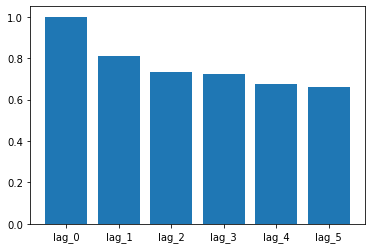

In [39]:
list(df.corr()['lag_0'].index)
plt.bar(list(df.corr()['lag_0'].index), list(df.corr()['lag_0']))

The error terms in a Moving Average process are built progressively by adjusting the error of the previous moment in time.  Each error term therein includes the indirect effect of the error term before it. Because of this, we can choose the MA term based on how many significant lags appear in the ACF.

![acf_ma1](img/ma1_acf.png)

Let's bring in the pacf and acf from statsmodels.

In [40]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

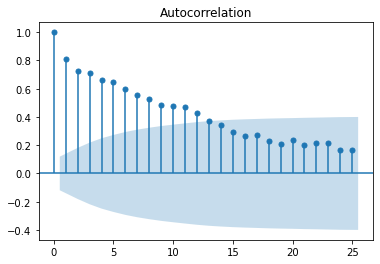

In [41]:
# Original data

plot_acf(train);

The above autocorrelation shows that there is correlation between lags up to about 12 weeks back.  

When Looking at the ACF graph for the original data, we see a strong persistent correlation with higher order lags. This is evidence that we should take a **first difference** of the data to remove this autocorrelation.

This makes sense, since we are trying to capture the effect of recent lags in our ARMA models, and with high correlation between distant lags, our models will not come close to the true process.

The shaded area of the graph is the convidence interval.  When the correlation drops into the shaded area, that means there is no longer statistically significant correlation between lags.

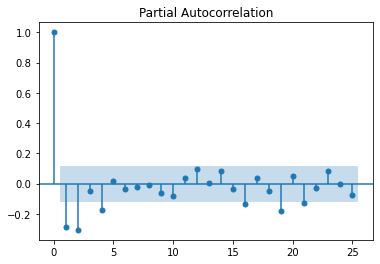

In [42]:
plot_pacf(train.diff().dropna());

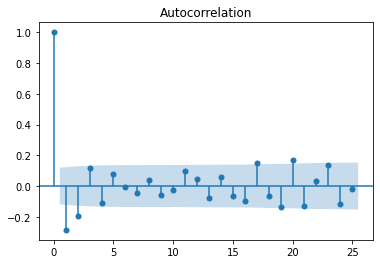

In [43]:
plot_acf(train.diff().dropna());

This autocorrelation plot can now be used to get an idea of a potential MA term.  Our differenced series shows negative significant correlation at lag of 1 suggests adding 1 MA term.  There is also a statistically significant 2nd, term, so adding another MA is another possibility.


> If the ACF of the differenced series displays a sharp cutoff and/or the lag-1 autocorrelation is negative--i.e., if the series appears slightly "overdifferenced"--then consider adding an MA term to the model. The lag at which the ACF cuts off is the indicated number of MA terms. [Duke](https://people.duke.edu/~rnau/411arim3.htm#signatures)

The plots above suggest that we should try a 1st order differenced MA(1) or MA(2) model on our weekly gun offense data.


The ACF can be used to identify the possible structure of time series data. That can be tricky going forward as there often isn’t a single clear-cut interpretation of a sample autocorrelation function.

Luckily, we have auto_arima

<a id='auto_arima'></a>

# auto_arima

Luckily for us, we have a Python package that will help us determine optimal terms.

In [44]:
!pip install pmdarima

     |████████████████████████████████| 592 kB 3.1 MB/s eta 0:00:01
     |████████████████████████████████| 9.5 MB 64.2 MB/s eta 0:00:01
     |████████████████████████████████| 15.6 MB 62.2 MB/s eta 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.18.5
    Uninstalling numpy-1.18.5:
      Successfully uninstalled numpy-1.18.5
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.0
    Uninstalling statsmodels-0.12.0:
      Successfully uninstalled statsmodels-0.12.0
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

tensorflow 2.3.1 requires numpy<1.19.0,>=1.16.0, but you'll have numpy 1.19.5 which is incompatible.


In [44]:
from pmdarima import auto_arima

auto_arima(train, start_p=0, start_q=0, max_p=6, max_q=3, seasonal=False, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1605.628, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1584.156, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1561.660, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1603.630, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1558.132, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1558.001, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1559.679, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1555.144, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1553.146, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1555.902, Time=0.04 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1555.145, Time=0.11 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1555.277, Time=0.06 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1555.821, Time=0.21 sec
 ARIMA(1,1,2)(0,0,0)[0]             : 

ARIMA(order=(1, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

According to auto_arima, our optimal model is a first order differenced, AR(1)MA(2) model.

Let's plot our training predictions.

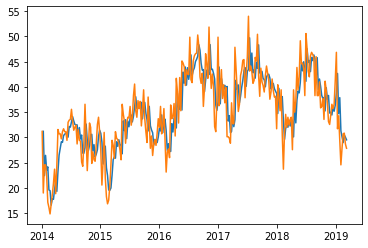

In [45]:
aa_model = ARIMA(train, (1,1,2)).fit()
y_hat_train = aa_model.predict(typ='levels')

fig, ax = plt.subplots()
ax.plot(y_hat_train)
ax.plot(train)

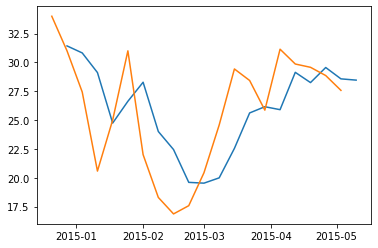

In [46]:
# Let's zoom in:

fig, ax = plt.subplots()
ax.plot(y_hat_train[50:70])
ax.plot(train[50:70])

In [47]:
aa_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  270
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -771.573
Method:                       css-mle   S.D. of innovations              4.212
Date:                Thu, 09 Sep 2021   AIC                           1553.146
Time:                        13:47:20   BIC                           1571.138
Sample:                    01-12-2014   HQIC                          1560.371
                         - 03-10-2019                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0121      0.112      0.108      0.914      -0.207       0.231
ar.L1.D.y     -0.5158      0.152     -3.397      0.001      -0.813      -0.218
ma.L1.D.y      0.1080      0.141      0.767      0.443      -0.168       0.384
ma.L2.D.y     -0.4519      0.068     -6.614      0.000      -0.586      -0.318
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.9389           +0.0000j            1.9389            0.5000
MA.1           -1.3728           +0.0000j            1.3728            0.5000
MA.2            1.6119           +0.0000j            1.6119            0.0000
-----------------------------------------------------------------------------
"""

In [48]:
rmse = np.sqrt(mean_squared_error(train[1:], y_hat_train))
rmse

4.225468219327218

# Test

Now that we have chosen our parameters, let's try our model on the test set.

In [49]:
test

2019-03-17    31.285714
2019-03-24    33.571429
2019-03-31    36.571429
2019-04-07    35.571429
2019-04-14    34.857143
                ...    
2020-05-31    55.157143
2020-06-07    59.771429
2020-06-14    50.142857
2020-06-21    53.857143
2020-06-28    54.500000
Freq: W-SUN, Length: 68, dtype: float64

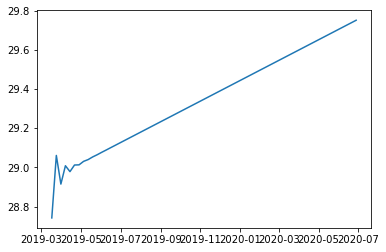

In [50]:
y_hat_test = aa_model.predict(start=test.index[0], end=test.index[-1],typ='levels')

fig, ax = plt.subplots()
ax.plot(y_hat_test)


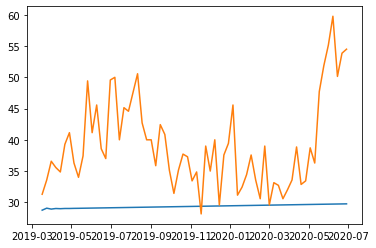

In [51]:
fig, ax = plt.subplots()
ax.plot(y_hat_test)
ax.plot(test)

In [52]:
np.sqrt(mean_squared_error(test, y_hat_test))

12.100169325166387

Our predictions on the test set certainly leave something to be desired.  

Let's take another look at our autocorrelation function of the original series.

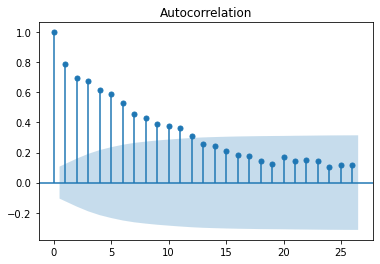

In [53]:
plot_acf(ts_weekly);

Let's increase the lags

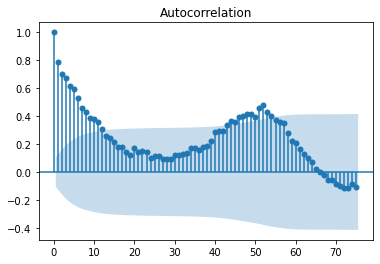

In [54]:
plot_acf(ts_weekly, lags=75);

There seems to be a wave of correlation at around 50 lags.
What is going on?

![verkempt](https://media.giphy.com/media/l3vRhBz4wCpJ9aEuY/giphy.gif)

# SARIMA

Looks like we may have some other forms of seasonality.  Luckily, we have SARIMA, which stands for Seasonal Auto Regressive Integrated Moving Average.  That is a lot.  The statsmodels package is actually called SARIMAX.  The X stands for exogenous, and we are only dealing with endogenous variables, but we can use SARIMAX as a SARIMA.


In [58]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

A seasonal ARIMA model is classified as an **ARIMA(p,d,q)x(P,D,Q)** model, 

    **p** = number of autoregressive (AR) terms 
    **d** = number of differences 
    **q** = number of moving average (MA) terms
     
    **P** = number of seasonal autoregressive (SAR) terms 
    **D** = number of seasonal differences 
    **Q** = number of seasonal moving average (SMA) terms

In [59]:
import itertools
p = q = range(0, 2)
pdq = list(itertools.product(p, [1], q))
seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, [1], q))]
print('Examples of parameter for SARIMA...')
for i in pdq:
    for s in seasonal_pdq:
        print('SARIMAX: {} x {}'.format(i, s))


Examples of parameter for SARIMA...
SARIMAX: (0, 1, 0) x (0, 1, 0, 52)
SARIMAX: (0, 1, 0) x (0, 1, 1, 52)
SARIMAX: (0, 1, 0) x (1, 1, 0, 52)
SARIMAX: (0, 1, 0) x (1, 1, 1, 52)
SARIMAX: (0, 1, 1) x (0, 1, 0, 52)
SARIMAX: (0, 1, 1) x (0, 1, 1, 52)
SARIMAX: (0, 1, 1) x (1, 1, 0, 52)
SARIMAX: (0, 1, 1) x (1, 1, 1, 52)
SARIMAX: (1, 1, 0) x (0, 1, 0, 52)
SARIMAX: (1, 1, 0) x (0, 1, 1, 52)
SARIMAX: (1, 1, 0) x (1, 1, 0, 52)
SARIMAX: (1, 1, 0) x (1, 1, 1, 52)
SARIMAX: (1, 1, 1) x (0, 1, 0, 52)
SARIMAX: (1, 1, 1) x (0, 1, 1, 52)
SARIMAX: (1, 1, 1) x (1, 1, 0, 52)
SARIMAX: (1, 1, 1) x (1, 1, 1, 52)


In [60]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod =SARIMAX(train,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{} - AIC:{}'.format(param,param_seasonal,results.aic))
        except: 
            print('hello')
            continue

ARIMA(0, 1, 0)x(0, 1, 0, 52) - AIC:1406.591491030544
ARIMA(0, 1, 0)x(0, 1, 1, 52) - AIC:1039.6273546177258
ARIMA(0, 1, 0)x(1, 1, 0, 52) - AIC:1055.4512482807786
ARIMA(0, 1, 0)x(1, 1, 1, 52) - AIC:1038.4190762650405
ARIMA(0, 1, 1)x(0, 1, 0, 52) - AIC:1326.2666858056523
ARIMA(0, 1, 1)x(0, 1, 1, 52) - AIC:978.1309943040908
ARIMA(0, 1, 1)x(1, 1, 0, 52) - AIC:1005.6947621195297
ARIMA(0, 1, 1)x(1, 1, 1, 52) - AIC:980.7133227206141
ARIMA(1, 1, 0)x(0, 1, 0, 52) - AIC:1373.0472465283535
ARIMA(1, 1, 0)x(0, 1, 1, 52) - AIC:1019.1651883768441
ARIMA(1, 1, 0)x(1, 1, 0, 52) - AIC:1024.5423831375442
ARIMA(1, 1, 0)x(1, 1, 1, 52) - AIC:1018.4857412836643
ARIMA(1, 1, 1)x(0, 1, 0, 52) - AIC:1320.7264572170375
ARIMA(1, 1, 1)x(0, 1, 1, 52) - AIC:973.5518935859591
ARIMA(1, 1, 1)x(1, 1, 0, 52) - AIC:988.5066193104026
ARIMA(1, 1, 1)x(1, 1, 1, 52) - AIC:975.311593785839


Let's try the third from the bottom, ARIMA(1, 1, 1)x(0, 1, 1, 52)12 - AIC:973.5518935855749

In [61]:
sari_mod =SARIMAX(train,order=(1,1,1),
                  seasonal_order=(0,1,1,52),
                  enforce_stationarity=False,
                  enforce_invertibility=False).fit()


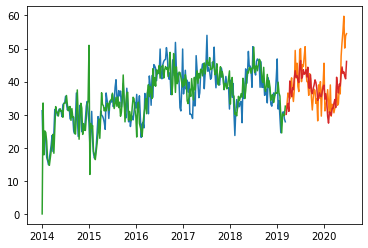

In [62]:
y_hat_train = sari_mod.predict(typ='levels')
y_hat_test = sari_mod.predict(start=test.index[0], end=test.index[-1],typ='levels')

fig, ax = plt.subplots()
ax.plot(train)
ax.plot(test)
ax.plot(y_hat_train)
ax.plot(y_hat_test)

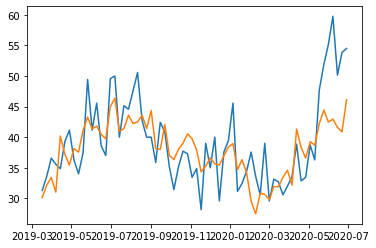

In [63]:
# Let's zoom in on test
fig, ax = plt.subplots()

ax.plot(test)
ax.plot(y_hat_test)


In [64]:
np.sqrt(mean_squared_error(test, y_hat_test))

5.06734403415317

# Forecast

Lastly, let's predict into the future.

To do so, we refit to our entire training set.

In [66]:
sari_mod =SARIMAX(ts_weekly,order=(1,1,1),seasonal_order=(0,1,1,52),enforce_stationarity=False,enforce_invertibility=False).fit()

In [67]:
forecast = sari_mod.forecast(steps = 52)

Text(0.5, 1.0, 'Chicago Gun Crime Predictions\n One Year out')

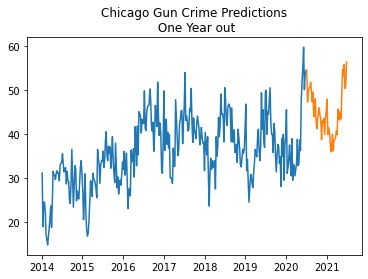

In [68]:
fig, ax = plt.subplots()

ax.plot(ts_weekly)
ax.plot(forecast)
ax.set_title('Chicago Gun Crime Predictions\n One Year out')